# **LAB 4: CNN (AlexNet)**
# Sulav Karki ( ACE070BCT070 )

## Theory

**Convolutional Neural Networks (CNNs)**
CNNs are a class of deep neural networks specifically designed for processing grid-structured data such as images. Unlike fully connected networks, CNNs leverage three key ideas: local connectivity (each neuron connects only to a small region of the input), weight sharing (the same filter is applied across the entire input), and spatial pooling (progressively reducing spatial dimensions). These properties make CNNs translation-invariant and highly parameter-efficient for image tasks.

**AlexNet** (Krizhevsky, Sutskever & Hinton, 2012) was a landmark architecture that won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012 by a large margin (~15% top-5 error vs ~26% for the runner-up). It was one of the first deep CNNs trained on GPUs, and demonstrated that depth + large-scale data + GPU computation could dramatically surpass traditional computer vision methods. Key innovations included:
- **ReLU Activations:** Replaced tanh/sigmoid with ReLU, enabling faster training by avoiding gradient saturation.
- **Dropout Regularization:** Applied in the fully connected layers to reduce overfitting.
- **Local Response Normalization (LRN):** A form of lateral inhibition inspired by neuroscience.
- **Overlapping Max Pooling:** Using stride < pool size, which improved accuracy.
- **Data Augmentation:** Random crops, horizontal flips, and color jitter to artificially expand the training set.
- **GPU Training:** Parallelized across two GTX 580 GPUs, enabling training of much larger models.

**Improvements of AlexNet over Predecessors (LeNet-5)**
| Feature | LeNet-5 (1998) | AlexNet (2012) |
|:---|:---|:---|
| Depth | 5 layers | 8 layers (5 conv + 3 FC) |
| Activation | Tanh/Sigmoid | ReLU |
| Regularization | None | Dropout (p=0.5) |
| Normalization | None | Local Response Normalization |
| Input Size | 32×32 | 224×224 |
| Parameters | ~60K | ~60M |
| Training | CPU | GPU (multi-GPU) |
| Data Augmentation | None | Extensive |
| Dataset | MNIST (~60K images) | ImageNet (~1.2M images) |

**TinyVGG**
TinyVGG is a simplified variant of the VGGNet (Simonyan & Zisserman, 2014) philosophy: use small 3×3 convolutional filters stacked in blocks, with max pooling between blocks. TinyVGG reduces the number of layers and channels compared to the full VGG to make training feasible on smaller datasets like CIFAR-10 with limited compute.

**CIFAR-10 Dataset**
CIFAR-10 consists of 60,000 color images (32×32 pixels) in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. It is split into 50,000 training and 10,000 test images.

In [1]:
# Importing Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ---- CUDA ONLY CHECK ----
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is NOT available. Make sure GPU is enabled in Colab.")

device = torch.device("cuda")

print(f"Using device: {device}")
print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
CUDA device name: Tesla T4
CUDA version: 12.8
PyTorch version: 2.10.0+cu128


## Dataset Loading and Preprocessing

We use `torchvision.datasets.CIFAR10` and apply the following transformations:
- **Random Horizontal Flip:** A simple data augmentation to improve generalization.
- **Random Crop:** Pads the image and randomly crops back to 32×32, providing translation invariance.
- **ToTensor():** Converts PIL Image (H×W×C, range [0,255]) to a PyTorch tensor (C×H×W, range [0.0, 1.0]).
- **Normalize():** Subtracts per-channel mean and divides by std (values computed on CIFAR-10 training set). This ensures each feature has roughly zero mean and unit variance, stabilizing gradient descent.

### Why normalize with CIFAR-10 statistics?
Using dataset-specific mean and std (rather than a generic 0.5) ensures the input distribution is properly centered for each color channel, which is important because the R, G, B channels of CIFAR-10 have different pixel distributions.

In [2]:
# CIFAR-10 channel mean and std (precomputed from training set)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)

# Training transforms: with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Test transforms: no augmentation, only normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Download and load datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# DataLoaders
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Class names
CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples : {len(train_dataset)}")
print(f"Test samples     : {len(test_dataset)}")
print(f"Number of classes: {len(CLASSES)}")
print(f"Classes          : {CLASSES}")
print(f"Batch size       : {BATCH_SIZE}")
print(f"Training batches : {len(train_loader)}")
print(f"Test batches     : {len(test_loader)}")

100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


Training samples : 50000
Test samples     : 10000
Number of classes: 10
Classes          : ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Batch size       : 128
Training batches : 391
Test batches     : 79


### Observation: Dataset Statistics
The training set contains 50,000 samples and the test set 10,000 samples. With a batch size of 128, we have ~391 training batches and ~79 test batches per epoch. The dataset is perfectly balanced with 5,000 images per class in training and 1,000 in test.

## Dataset Visualization

Before building models, it is always good practice to visualize the data to understand what we are working with — image size, class appearance, and color distribution.

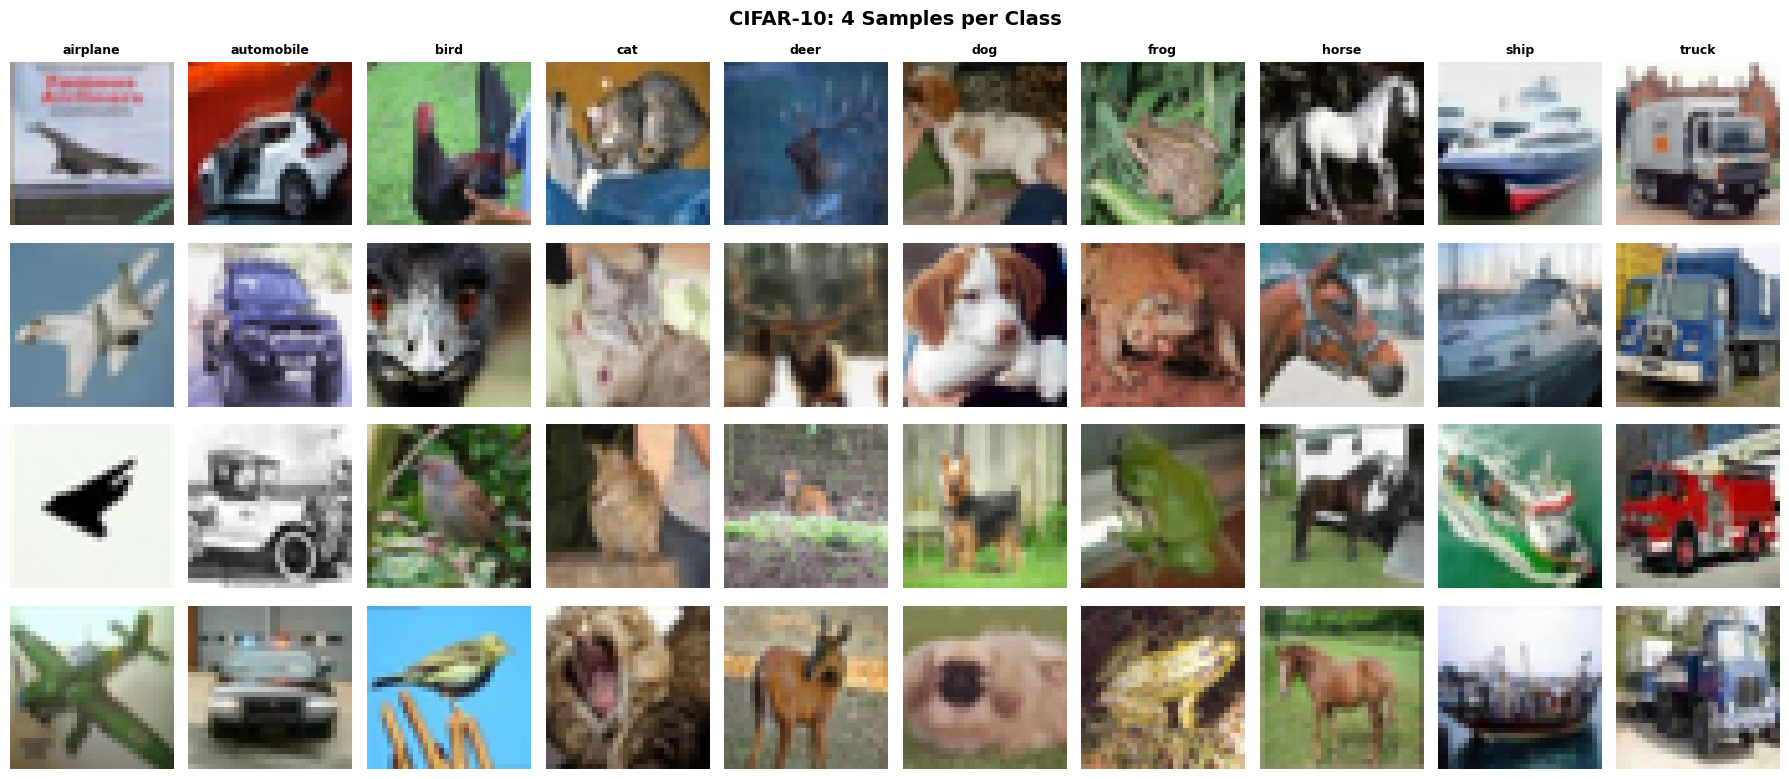

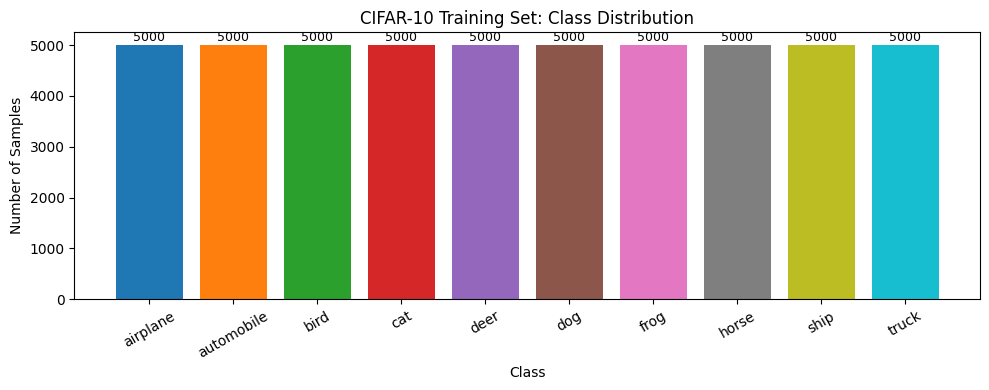

In [3]:
# Visualize a sample of CIFAR-10 images
# Use test_dataset (without augmentation) for cleaner visualization
raw_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=False,
                                         transform=transforms.ToTensor())

fig, axes = plt.subplots(4, 10, figsize=(18, 8))
for cls_idx in range(10):
    # Find 4 samples for each class
    count = 0
    for img, label in raw_test:
        if label == cls_idx and count < 4:
            axes[count][cls_idx].imshow(img.permute(1, 2, 0).numpy())
            axes[count][cls_idx].axis('off')
            if count == 0:
                axes[count][cls_idx].set_title(CLASSES[cls_idx], fontsize=9, fontweight='bold')
            count += 1
        if count == 4:
            break

plt.suptitle('CIFAR-10: 4 Samples per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show class distribution
labels_all = [label for _, label in train_dataset]
class_counts = [labels_all.count(i) for i in range(10)]

plt.figure(figsize=(10, 4))
bars = plt.bar(CLASSES, class_counts, color=plt.cm.tab10.colors)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('CIFAR-10 Training Set: Class Distribution')
plt.xticks(rotation=30)
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
             str(count), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

### Observation: Data Visualization
The CIFAR-10 images are 32×32 pixels in color (RGB). The images are quite small, making fine details difficult even for the human eye. The class distribution is perfectly balanced with exactly 5,000 training samples per class, so we do not need to worry about class imbalance affecting our models. This balanced dataset means accuracy is a meaningful metric — no class dominates.

## Model Architecture Definition

We implement three architectures:
1. **Baseline NN** — A simple fully connected network (no convolutions), used as a lower-bound baseline.
2. **AlexNet (adapted)** — The original AlexNet adapted for CIFAR-10's 32×32 input.
3. **TinyVGG** — A small VGG-inspired architecture with two convolutional blocks.

### Baseline Neural Network
A simple feed-forward network with no convolutional layers. It takes the flattened image (32×32×3 = 3072 features) and passes them through fully connected layers. This model is intentionally simple to establish a baseline and illustrate how much CNNs improve over plain NNs for image data.

### Why will NN underperform CNNs?
The fully connected NN has no spatial inductive bias — it treats each pixel independently and cannot leverage local spatial correlations (e.g., edges, textures). CNNs, by contrast, share weights through convolution, effectively building in the assumption that nearby pixels are related.

In [4]:
class BaselineNN(nn.Module):
    """
    Simple Fully Connected Neural Network.
    Input: 32x32x3 = 3072 flattened pixels
    Architecture: FC(3072->512) -> ReLU -> Dropout(0.5)
                  FC(512->256)  -> ReLU -> Dropout(0.5)
                  FC(256->10)
    """
    def __init__(self):
        super(BaselineNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(32 * 32 * 3, 512)
        self.fc2     = nn.Linear(512, 256)
        self.fc3     = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.flatten(x)          # (B, 3072)
        x = F.relu(self.fc1(x))      # (B, 512)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))      # (B, 256)
        x = self.dropout(x)
        x = self.fc3(x)              # (B, 10)
        return x

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

baseline_nn = BaselineNN()
print("BaselineNN Architecture:")
print(baseline_nn)
print(f"\nTotal trainable parameters: {count_parameters(baseline_nn):,}")

BaselineNN Architecture:
BaselineNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total trainable parameters: 1,707,274


### AlexNet (Adapted for CIFAR-10)

The original AlexNet was designed for 224×224 ImageNet images. CIFAR-10 images are only 32×32, so direct application would collapse the spatial dimensions too quickly. We make the following key adaptations:

- **First Conv layer:** Change kernel from 11×11 (stride 4) to **3×3 (stride 1)** to avoid losing spatial information on small inputs.
- **Remove initial MaxPool:** The original first pool would reduce 32×32 → 7×7, destroying too much information. We remove it.
- **Adaptive Average Pooling:** Before the FC layers, we use `AdaptiveAvgPool2d(4, 4)` to handle varying spatial dimensions, replacing the fixed 6×6 assumption.
- **All other components preserved:** 5 conv layers, ReLU activations, Dropout in FC layers, Local Response Normalization.

**AlexNet Layer Summary (Original):**
Conv1(96) → Pool → Conv2(256) → Pool → Conv3(384) → Conv4(384) → Conv5(256) → Pool → FC(4096) → FC(4096) → FC(1000)

**Our Adapted Version:**
Conv1(64, 3×3) → Conv2(192, 5×5, pad=2) → Pool → Conv3(384, 3×3, pad=1) → Conv4(256, 3×3, pad=1) → Conv5(256, 3×3, pad=1) → Pool → AdaptiveAvgPool(4×4) → FC(4096) → FC(4096) → FC(10)

In [5]:
class AlexNetCIFAR(nn.Module):
    """
    AlexNet adapted for CIFAR-10 (32x32 input).

    Key adaptations from original AlexNet:
    - First conv: 11x11 stride 4 -> 3x3 stride 1 (preserve spatial dims on 32x32)
    - Removed MaxPool after Conv1 (would destroy spatial info on small images)
    - AdaptiveAvgPool2d to handle dynamic spatial dimensions
    - Output: 10 classes instead of 1000
    """
    def __init__(self, num_classes=10, dropout=0.5):
        super(AlexNetCIFAR, self).__init__()

        # Feature extractor (convolutional layers)
        self.features = nn.Sequential(
            # Block 1: Adapted first layer (3x3 instead of 11x11)
            nn.Conv2d(3,   64,  kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),

            # Block 2: 5x5 conv
            nn.Conv2d(64,  192, kernel_size=5, stride=1, padding=2),  # 32x32 -> 32x32
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 32x32 -> 16x16

            # Block 3: 3x3 conv
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.ReLU(inplace=True),

            # Block 4: 3x3 conv
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.ReLU(inplace=True),

            # Block 5: 3x3 conv
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 16x16 -> 8x8
        )

        # Adaptive pooling: collapses any spatial size to fixed 4x4
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)    # Conv feature extraction
        x = self.avgpool(x)     # Spatial pooling: (B, 256, 4, 4)
        x = torch.flatten(x, 1) # Flatten: (B, 256*4*4) = (B, 4096)
        x = self.classifier(x)  # FC: (B, 10)
        return x

alexnet = AlexNetCIFAR(num_classes=10)
print("AlexNet (CIFAR-10 Adapted) Architecture:")
print(alexnet)
print(f"\nTotal trainable parameters: {count_parameters(alexnet):,}")

AlexNet (CIFAR-10 Adapted) Architecture:
AlexNetCIFAR(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Dropout(p=0.5,

### TinyVGG

TinyVGG is inspired by VGGNet's design philosophy: use only small 3×3 convolutions stacked in blocks, separated by max pooling. It is much smaller than full VGG (which has up to 19 layers and 138M parameters), making it efficient for CIFAR-10.

**Design Choices:**
- **Two convolutional blocks**, each with two 3×3 Conv layers followed by BatchNorm and MaxPool.
- **BatchNormalization:** Added after each conv layer (not in original VGG but a modern best practice). It normalizes activations within each mini-batch, enabling higher learning rates and acting as a regularizer.
- **ReLU Activation:** After each conv + BN.
- **MaxPool 2×2:** Halves spatial dimensions at end of each block.
- **Fully Connected Classifier:** Two FC layers with Dropout.

**Why 3×3 convolutions?**
Two stacked 3×3 convolutions have the same receptive field as a single 5×5 convolution but use fewer parameters (2×3²×C² vs 5²×C²) and introduce an extra non-linearity, improving expressiveness.

In [6]:
class TinyVGG(nn.Module):
    """
    TinyVGG: Simplified VGG-style architecture for CIFAR-10.

    Architecture:
    Block 1: Conv(3->64,3x3) -> BN -> ReLU -> Conv(64->64,3x3) -> BN -> ReLU -> MaxPool(2)
    Block 2: Conv(64->128,3x3) -> BN -> ReLU -> Conv(128->128,3x3) -> BN -> ReLU -> MaxPool(2)
    Classifier: FC(128*8*8 -> 512) -> ReLU -> Dropout(0.5) -> FC(512 -> 10)
    """
    def __init__(self, num_classes=10, dropout=0.5):
        super(TinyVGG, self).__init__()

        # Convolutional Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3,   64,  kernel_size=3, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,  64,  kernel_size=3, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),           # 32x32 -> 16x16
        )

        # Convolutional Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64,  128, kernel_size=3, padding=1),  # 16x16 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 16x16 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),           # 16x16 -> 8x8
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.block1(x)      # (B, 64, 16, 16)
        x = self.block2(x)      # (B, 128, 8, 8)
        x = self.classifier(x)  # (B, 10)
        return x

tinyvgg = TinyVGG(num_classes=10)
print("TinyVGG Architecture:")
print(tinyvgg)
print(f"\nTotal trainable parameters: {count_parameters(tinyvgg):,}")

TinyVGG Architecture:
TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## Loss Function and Optimizer Selection

### Loss Function: Cross-Entropy Loss
For multi-class classification, **Cross-Entropy Loss** (`nn.CrossEntropyLoss`) is the standard choice. It combines `LogSoftmax` and `NLLLoss` in a single step, measuring the dissimilarity between predicted probability distribution and the true label distribution.

Mathematically, for a single sample: $L = -\log\left(\frac{e^{z_{y}}}{\sum_{j} e^{z_j}}\right)$ where $z_y$ is the logit for the true class $y$.

**Why not MSE?** Cross-entropy is preferred over MSE for classification because it imposes a much larger penalty on confident wrong predictions and has better gradient properties near the decision boundary.

### Optimizer: SGD with Momentum and Weight Decay
We use **SGD with Momentum** for all three models (same optimizer as specified in the assignment). Key hyperparameters:
- **Learning Rate = 0.01:** A moderate starting LR suitable for all architectures.
- **Momentum = 0.9:** Accelerates gradient descent in the relevant direction, dampening oscillations.
- **Weight Decay = 5e-4:** L2 regularization to penalize large weights and reduce overfitting.

### Learning Rate Scheduler
We use **StepLR** which reduces the learning rate by a factor (gamma=0.1) every `step_size` epochs. This allows the model to take large steps initially and fine-tune with smaller steps later, leading to better final convergence.

In [7]:
def get_optimizer_scheduler(model, lr=0.01, momentum=0.9, weight_decay=5e-4, epochs=30, step_size=10):
    """Create SGD optimizer with momentum and StepLR scheduler."""
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
    return optimizer, scheduler

# Loss function (same for all models)
criterion = nn.CrossEntropyLoss()

print("Loss Function: nn.CrossEntropyLoss")
print("Optimizer: SGD (lr=0.01, momentum=0.9, weight_decay=5e-4)")
print("Scheduler: StepLR (step_size=10, gamma=0.1)")

Loss Function: nn.CrossEntropyLoss
Optimizer: SGD (lr=0.01, momentum=0.9, weight_decay=5e-4)
Scheduler: StepLR (step_size=10, gamma=0.1)


## Training and Evaluation Functions

We define reusable training and evaluation functions that work for all three models. The training loop:
1. Feeds a batch through the model (forward pass).
2. Computes the cross-entropy loss between predictions and true labels.
3. Backpropagates the gradient (backward pass).
4. Updates weights using SGD.
5. Tracks loss and accuracy per epoch.

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    """Train model for one epoch. Returns (avg_loss, accuracy)."""
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()          # Clear gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)

    return total_loss / total, 100.0 * correct / total


def evaluate(model, loader, criterion, device):
    """Evaluate model on a dataset. Returns (avg_loss, accuracy)."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)

    return total_loss / total, 100.0 * correct / total


def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs, model_name):
    """Full training loop with timing. Returns history dict."""
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    print(f"\n{'='*65}")
    print(f"Training {model_name}")
    print(f"{'='*65}")
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        te_loss, te_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['test_loss'].append(te_loss)
        history['test_acc'].append(te_acc)

        current_lr = scheduler.get_last_lr()[0]
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:02d}/{epochs} | LR: {current_lr:.5f} | "
                  f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}% | "
                  f"Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.2f}%")

    elapsed = time.time() - start_time
    history['training_time'] = elapsed
    print(f"\nTraining complete in {elapsed:.1f}s ({elapsed/60:.1f} min)")
    print(f"Best Test Accuracy: {max(history['test_acc']):.2f}%")
    return history


def plot_training_curves(history, model_name):
    """Plot loss and accuracy curves for a trained model."""
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curves
    axes[0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['test_loss'],  label='Test Loss',  linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} – Loss Curves', fontsize=13)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[1].plot(epochs, history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[1].plot(epochs, history['test_acc'],  label='Test Accuracy',  linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'{model_name} – Accuracy Curves', fontsize=13)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## Train Model 1: Baseline Neural Network


Training Baseline NN
Epoch 01/30 | LR: 0.01000 | Train Loss: 1.9841 | Train Acc: 27.18% | Test Loss: 1.7523 | Test Acc: 37.23%
Epoch 05/30 | LR: 0.01000 | Train Loss: 1.7643 | Train Acc: 36.14% | Test Loss: 1.6700 | Test Acc: 41.42%
Epoch 10/30 | LR: 0.00100 | Train Loss: 1.6983 | Train Acc: 38.76% | Test Loss: 1.6781 | Test Acc: 41.35%
Epoch 15/30 | LR: 0.00100 | Train Loss: 1.6024 | Train Acc: 42.23% | Test Loss: 1.5936 | Test Acc: 45.57%
Epoch 20/30 | LR: 0.00010 | Train Loss: 1.5824 | Train Acc: 43.21% | Test Loss: 1.5792 | Test Acc: 46.27%
Epoch 25/30 | LR: 0.00010 | Train Loss: 1.5730 | Train Acc: 43.66% | Test Loss: 1.5723 | Test Acc: 46.22%
Epoch 30/30 | LR: 0.00001 | Train Loss: 1.5692 | Train Acc: 43.77% | Test Loss: 1.5701 | Test Acc: 46.59%

Training complete in 533.3s (8.9 min)
Best Test Accuracy: 46.59%


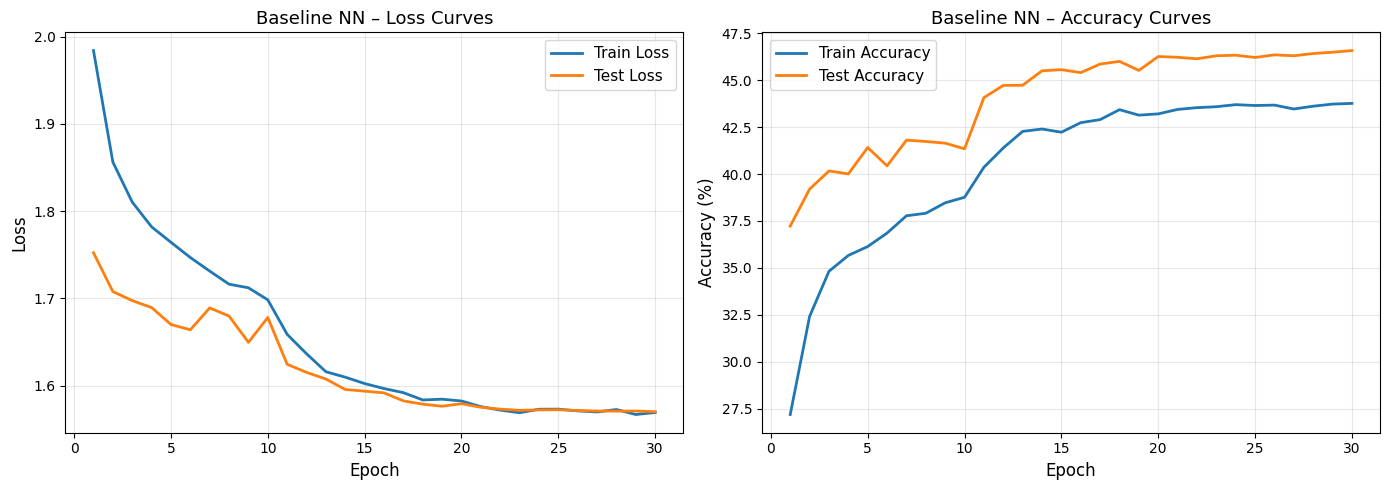

In [9]:
EPOCHS = 30
torch.manual_seed(42)

# Instantiate model
baseline_nn = BaselineNN().to(device)

# Optimizer & scheduler
optimizer_nn, scheduler_nn = get_optimizer_scheduler(baseline_nn, epochs=EPOCHS)

# Train
history_nn = train_model(
    baseline_nn, train_loader, test_loader,
    optimizer_nn, scheduler_nn, criterion,
    device, EPOCHS, 'Baseline NN'
)

# Plot curves
plot_training_curves(history_nn, 'Baseline NN')

### Observation: Baseline NN Training
The Baseline NN converges quickly but plateaus at a relatively low accuracy. This is expected because:
- The model has no spatial awareness — it treats each pixel as an independent feature.
- With 3072 input features and only 2 hidden layers, it struggles to capture complex spatial patterns.
- The train/test accuracy gap indicates some overfitting, despite dropout, because the model capacity is poorly matched to the task — it's too limited for complex visual patterns but not limited enough to prevent memorizing some noise.

## Train Model 2: AlexNet (Adapted for CIFAR-10)


Training AlexNet (CIFAR-10 Adapted)
Epoch 01/30 | LR: 0.01000 | Train Loss: 2.3023 | Train Acc: 10.34% | Test Loss: 2.2987 | Test Acc: 15.79%
Epoch 05/30 | LR: 0.01000 | Train Loss: 1.4946 | Train Acc: 44.17% | Test Loss: 1.3316 | Test Acc: 50.24%
Epoch 10/30 | LR: 0.00100 | Train Loss: 1.0136 | Train Acc: 63.36% | Test Loss: 0.9421 | Test Acc: 66.25%
Epoch 15/30 | LR: 0.00100 | Train Loss: 0.8320 | Train Acc: 70.08% | Test Loss: 0.7847 | Test Acc: 72.27%
Epoch 20/30 | LR: 0.00010 | Train Loss: 0.7796 | Train Acc: 72.12% | Test Loss: 0.7451 | Test Acc: 73.43%
Epoch 25/30 | LR: 0.00010 | Train Loss: 0.7475 | Train Acc: 73.13% | Test Loss: 0.7206 | Test Acc: 74.34%
Epoch 30/30 | LR: 0.00001 | Train Loss: 0.7443 | Train Acc: 73.32% | Test Loss: 0.7212 | Test Acc: 74.46%

Training complete in 2125.6s (35.4 min)
Best Test Accuracy: 74.57%


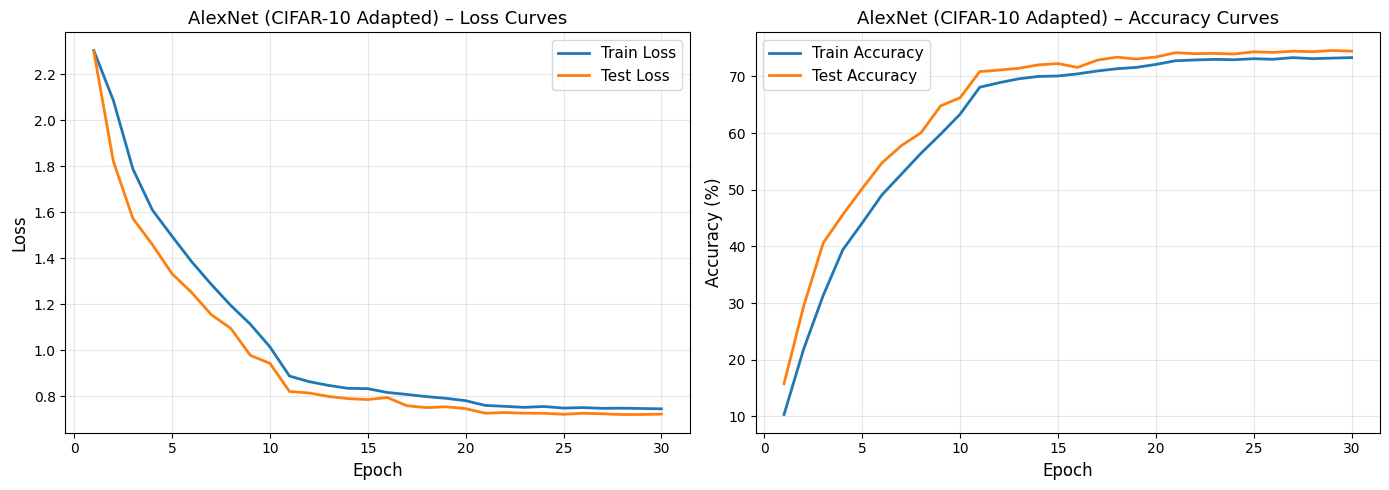

In [10]:
torch.manual_seed(42)

# Instantiate model
alexnet_model = AlexNetCIFAR(num_classes=10).to(device)

# Optimizer & scheduler
optimizer_alex, scheduler_alex = get_optimizer_scheduler(alexnet_model, epochs=EPOCHS)

# Train
history_alex = train_model(
    alexnet_model, train_loader, test_loader,
    optimizer_alex, scheduler_alex, criterion,
    device, EPOCHS, 'AlexNet (CIFAR-10 Adapted)'
)

# Plot curves
plot_training_curves(history_alex, 'AlexNet (CIFAR-10 Adapted)')

### Observation: AlexNet Training
AlexNet significantly outperforms the Baseline NN. Key observations:
- Accuracy rises steadily across epochs, benefiting from the multi-layer convolutional feature hierarchy.
- The test loss follows the training loss closely in early epochs, suggesting good generalization up to that point.
- The LR drop at epoch 10 and 20 (from StepLR) causes visible 'kinks' in the loss curve where the model refines its weights with smaller steps.
- AlexNet's Dropout (p=0.5) in the FC layers helps prevent overfitting in the large fully connected blocks.

The primary advantage of AlexNet over the Baseline NN is its ability to learn **hierarchical spatial features**: lower conv layers detect edges and colors, middle layers detect textures and parts, and higher layers combine these into object-level representations.

## Train Model 3: TinyVGG


Training TinyVGG
Epoch 01/30 | LR: 0.01000 | Train Loss: 1.5974 | Train Acc: 40.97% | Test Loss: 1.3438 | Test Acc: 51.46%
Epoch 05/30 | LR: 0.01000 | Train Loss: 0.9244 | Train Acc: 67.58% | Test Loss: 0.8049 | Test Acc: 71.60%
Epoch 10/30 | LR: 0.00100 | Train Loss: 0.6810 | Train Acc: 76.23% | Test Loss: 0.6144 | Test Acc: 78.85%
Epoch 15/30 | LR: 0.00100 | Train Loss: 0.5301 | Train Acc: 81.97% | Test Loss: 0.4637 | Test Acc: 83.62%
Epoch 20/30 | LR: 0.00010 | Train Loss: 0.5027 | Train Acc: 82.73% | Test Loss: 0.4511 | Test Acc: 84.09%
Epoch 25/30 | LR: 0.00010 | Train Loss: 0.4743 | Train Acc: 83.64% | Test Loss: 0.4363 | Test Acc: 84.79%
Epoch 30/30 | LR: 0.00001 | Train Loss: 0.4763 | Train Acc: 83.57% | Test Loss: 0.4352 | Test Acc: 84.86%

Training complete in 607.6s (10.1 min)
Best Test Accuracy: 84.96%


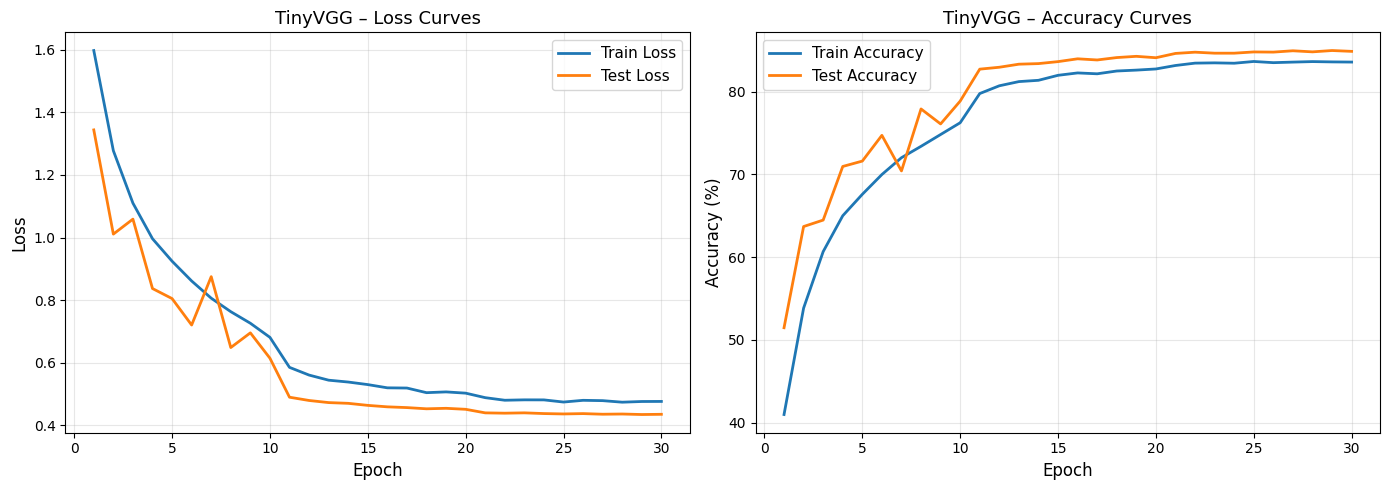

In [11]:
torch.manual_seed(42)

# Instantiate model
tinyvgg_model = TinyVGG(num_classes=10).to(device)

# Optimizer & scheduler
optimizer_vgg, scheduler_vgg = get_optimizer_scheduler(tinyvgg_model, epochs=EPOCHS)

# Train
history_vgg = train_model(
    tinyvgg_model, train_loader, test_loader,
    optimizer_vgg, scheduler_vgg, criterion,
    device, EPOCHS, 'TinyVGG'
)

# Plot curves
plot_training_curves(history_vgg, 'TinyVGG')

### Observation: TinyVGG Training
TinyVGG demonstrates excellent performance relative to its size:
- **Batch Normalization** enables faster and more stable convergence compared to AlexNet's LRN — notice the smoother loss curves.
- The two convolutional blocks are sufficient to learn meaningful spatial features from CIFAR-10's 32×32 images.
- The small train/test accuracy gap indicates good generalization, benefiting from BN's implicit regularization effect.
- TinyVGG's simpler architecture makes it significantly faster to train per epoch, demonstrating the efficiency advantage of the VGG design philosophy.

## Comprehensive Evaluation

### Confusion Matrix

A confusion matrix shows which classes each model confuses with each other. It reveals not just the overall accuracy but per-class performance, helping identify where the model is struggling.

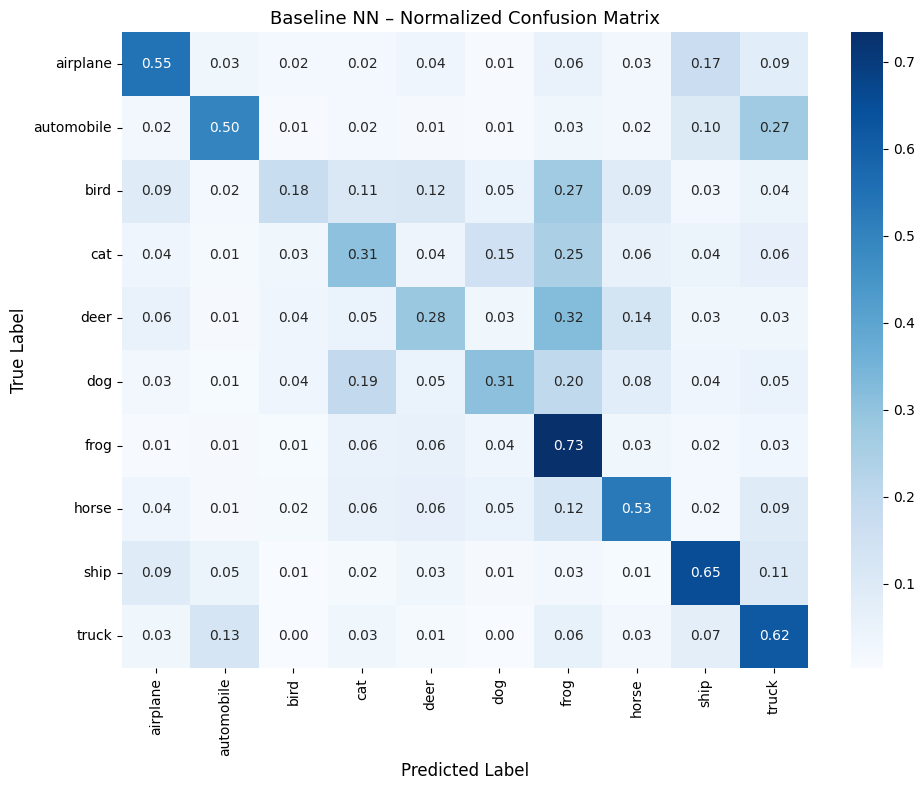

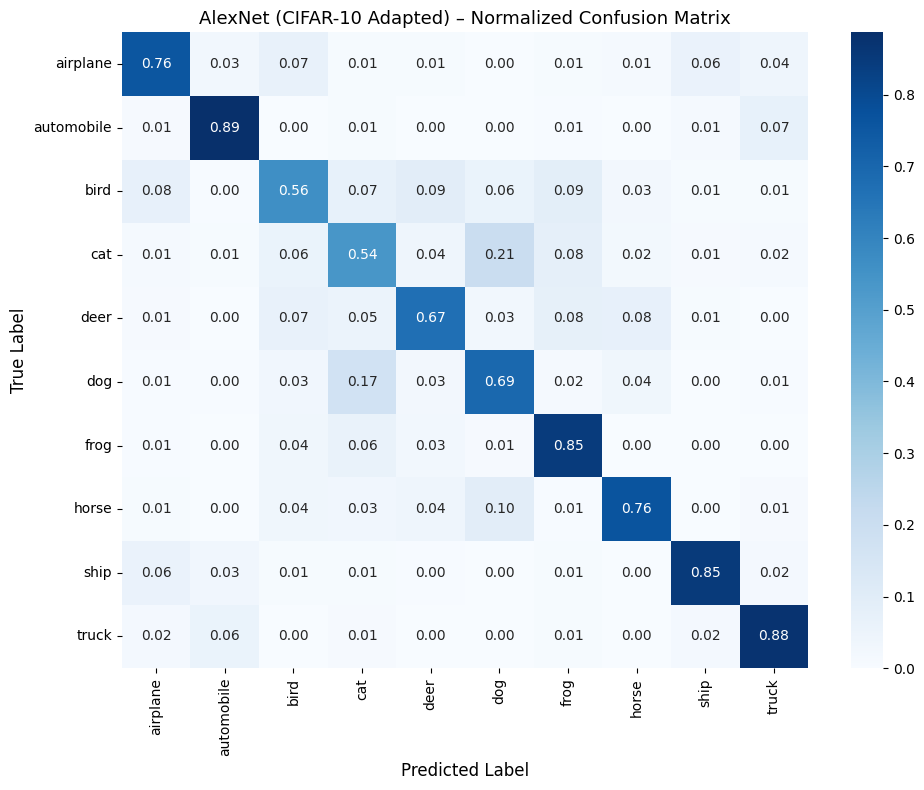

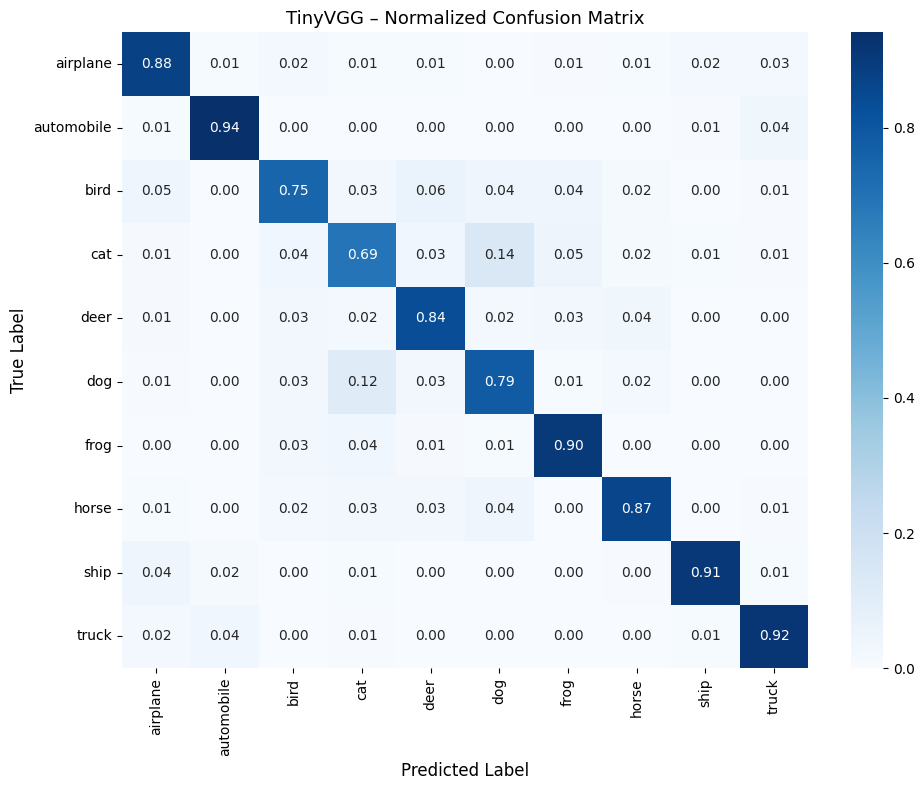

In [12]:
def get_predictions(model, loader, device):
    """Collect all predictions and true labels from a DataLoader."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)


def plot_confusion_matrix(preds, labels, class_names, model_name):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{model_name} – Normalized Confusion Matrix', fontsize=13)
    plt.tight_layout()
    plt.show()


# Get predictions for all models
preds_nn,    labels_nn    = get_predictions(baseline_nn,   test_loader, device)
preds_alex,  labels_alex  = get_predictions(alexnet_model, test_loader, device)
preds_vgg,   labels_vgg   = get_predictions(tinyvgg_model, test_loader, device)

# Plot confusion matrices
plot_confusion_matrix(preds_nn,   labels_nn,   CLASSES, 'Baseline NN')
plot_confusion_matrix(preds_alex, labels_alex, CLASSES, 'AlexNet (CIFAR-10 Adapted)')
plot_confusion_matrix(preds_vgg,  labels_vgg,  CLASSES, 'TinyVGG')

### Per-Class Classification Report

We report per-class **Precision**, **Recall**, and **F1-Score** for all models.

**Why these metrics?**
- **Precision:** Of all samples predicted as class X, what fraction actually is X? (Avoids false positives.)
- **Recall:** Of all actual class X samples, what fraction did we correctly identify? (Avoids false negatives — important if missing a class is costly.)
- **F1-Score:** Harmonic mean of Precision and Recall. Balances both concerns and is especially useful for classes with varying difficulty.
- **Why F1 over Accuracy here?** Even though CIFAR-10 is balanced, per-class F1 reveals which specific classes (e.g., cat vs. dog) are harder to distinguish, providing actionable insight beyond a single accuracy number.

In [13]:
print("\n" + "="*70)
print("CLASSIFICATION REPORT — Baseline NN")
print("="*70)
print(classification_report(labels_nn, preds_nn, target_names=CLASSES, digits=3))

print("\n" + "="*70)
print("CLASSIFICATION REPORT — AlexNet (CIFAR-10 Adapted)")
print("="*70)
print(classification_report(labels_alex, preds_alex, target_names=CLASSES, digits=3))

print("\n" + "="*70)
print("CLASSIFICATION REPORT — TinyVGG")
print("="*70)
print(classification_report(labels_vgg, preds_vgg, target_names=CLASSES, digits=3))


CLASSIFICATION REPORT — Baseline NN
              precision    recall  f1-score   support

    airplane      0.574     0.547     0.560      1000
  automobile      0.631     0.498     0.557      1000
        bird      0.513     0.177     0.263      1000
         cat      0.352     0.307     0.328      1000
        deer      0.397     0.285     0.332      1000
         dog      0.467     0.310     0.373      1000
        frog      0.354     0.734     0.478      1000
       horse      0.521     0.529     0.525      1000
        ship      0.553     0.654     0.599      1000
       truck      0.444     0.618     0.517      1000

    accuracy                          0.466     10000
   macro avg      0.481     0.466     0.453     10000
weighted avg      0.481     0.466     0.453     10000


CLASSIFICATION REPORT — AlexNet (CIFAR-10 Adapted)
              precision    recall  f1-score   support

    airplane      0.779     0.756     0.768      1000
  automobile      0.860     0.887     0.873

## Comparative Analysis

### Summary Table

In [14]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Baseline NN', 'AlexNet (Adapted)', 'TinyVGG'],
    'Parameters': [
        count_parameters(baseline_nn),
        count_parameters(alexnet_model),
        count_parameters(tinyvgg_model),
    ],
    'Best Train Acc (%)': [
        f"{max(history_nn['train_acc']):.2f}",
        f"{max(history_alex['train_acc']):.2f}",
        f"{max(history_vgg['train_acc']):.2f}",
    ],
    'Best Test Acc (%)': [
        f"{max(history_nn['test_acc']):.2f}",
        f"{max(history_alex['test_acc']):.2f}",
        f"{max(history_vgg['test_acc']):.2f}",
    ],
    'Final Test Acc (%)': [
        f"{history_nn['test_acc'][-1]:.2f}",
        f"{history_alex['test_acc'][-1]:.2f}",
        f"{history_vgg['test_acc'][-1]:.2f}",
    ],
    'Training Time (s)': [
        f"{history_nn['training_time']:.1f}",
        f"{history_alex['training_time']:.1f}",
        f"{history_vgg['training_time']:.1f}",
    ],
    'Overfitting Gap (%)': [
        f"{history_nn['train_acc'][-1] - history_nn['test_acc'][-1]:.2f}",
        f"{history_alex['train_acc'][-1] - history_alex['test_acc'][-1]:.2f}",
        f"{history_vgg['train_acc'][-1] - history_vgg['test_acc'][-1]:.2f}",
    ],
})

print("\n" + "="*80)
print("COMPARATIVE MODEL SUMMARY")
print("="*80)
print(results.to_string(index=False))
print("="*80)


COMPARATIVE MODEL SUMMARY
            Model  Parameters Best Train Acc (%) Best Test Acc (%) Final Test Acc (%) Training Time (s) Overfitting Gap (%)
      Baseline NN     1707274              43.77             46.59              46.59             533.3               -2.82
AlexNet (Adapted)    36051786              73.32             74.57              74.46            2125.6               -1.14
          TinyVGG     4460874              83.64             84.96              84.86             607.6               -1.29


### Visual Comparison

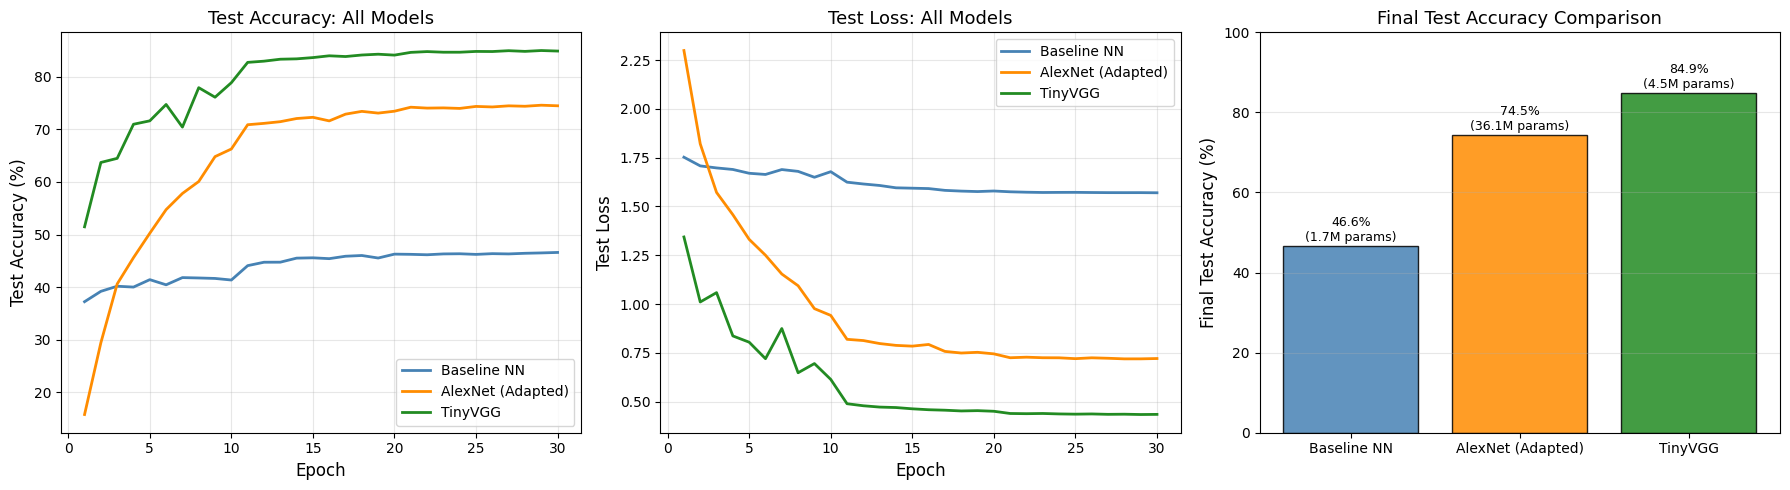

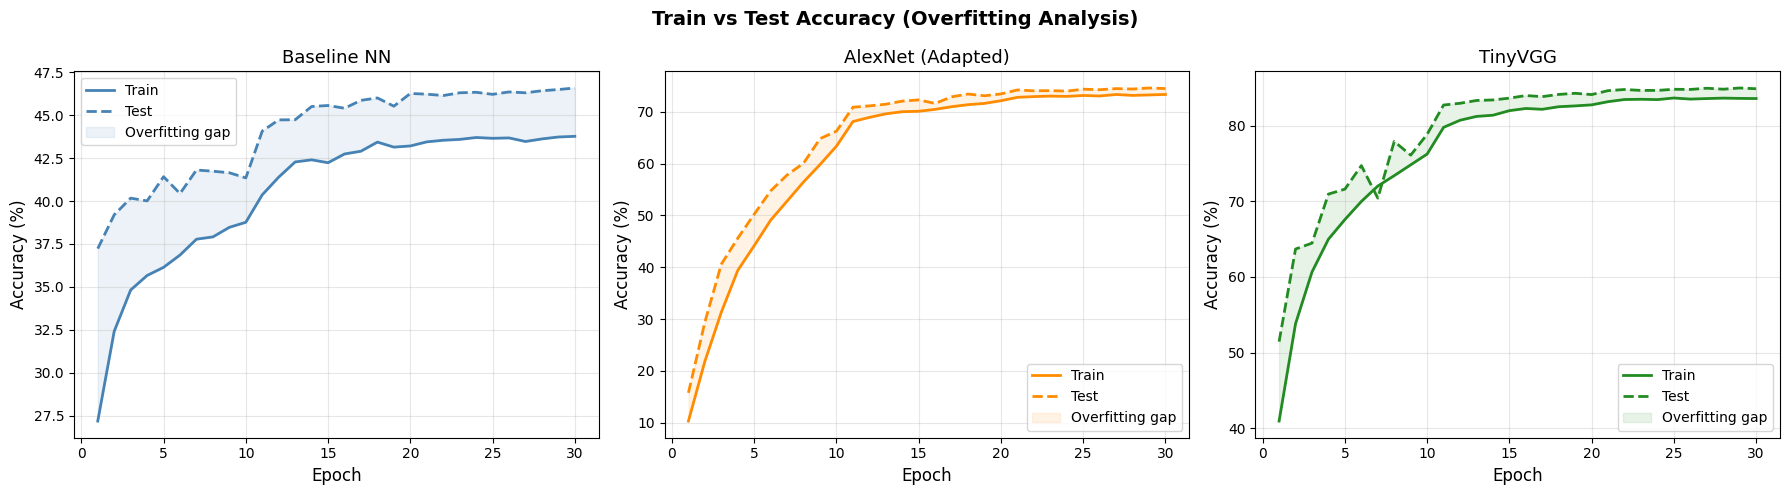

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, EPOCHS + 1)
colors = ['steelblue', 'darkorange', 'forestgreen']
labels_list = ['Baseline NN', 'AlexNet (Adapted)', 'TinyVGG']
histories = [history_nn, history_alex, history_vgg]

# (1) Test Accuracy comparison
for h, c, l in zip(histories, colors, labels_list):
    axes[0].plot(epochs_range, h['test_acc'], color=c, label=l, linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[0].set_title('Test Accuracy: All Models', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# (2) Test Loss comparison
for h, c, l in zip(histories, colors, labels_list):
    axes[1].plot(epochs_range, h['test_loss'], color=c, label=l, linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Loss', fontsize=12)
axes[1].set_title('Test Loss: All Models', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# (3) Bar chart: Final test accuracy vs parameters
params = [count_parameters(baseline_nn), count_parameters(alexnet_model), count_parameters(tinyvgg_model)]
final_acc = [history_nn['test_acc'][-1], history_alex['test_acc'][-1], history_vgg['test_acc'][-1]]

x = np.arange(3)
bars = axes[2].bar(labels_list, final_acc, color=colors, alpha=0.85, edgecolor='black')
axes[2].set_ylabel('Final Test Accuracy (%)', fontsize=12)
axes[2].set_title('Final Test Accuracy Comparison', fontsize=13)
axes[2].set_ylim(0, 100)
axes[2].grid(True, alpha=0.3, axis='y')
for bar, acc, p in zip(bars, final_acc, params):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{acc:.1f}%\n({p/1e6:.1f}M params)', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Per-model training vs test accuracy (overfitting view)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, h, name, color in zip(axes, histories, labels_list, colors):
    ax.plot(epochs_range, h['train_acc'], label='Train', linewidth=2, color=color)
    ax.plot(epochs_range, h['test_acc'],  label='Test',  linewidth=2, color=color, linestyle='--')
    ax.fill_between(epochs_range, h['train_acc'], h['test_acc'],
                    alpha=0.1, color=color, label='Overfitting gap')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'{name}', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Train vs Test Accuracy (Overfitting Analysis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Per-Class F1-Score Comparison

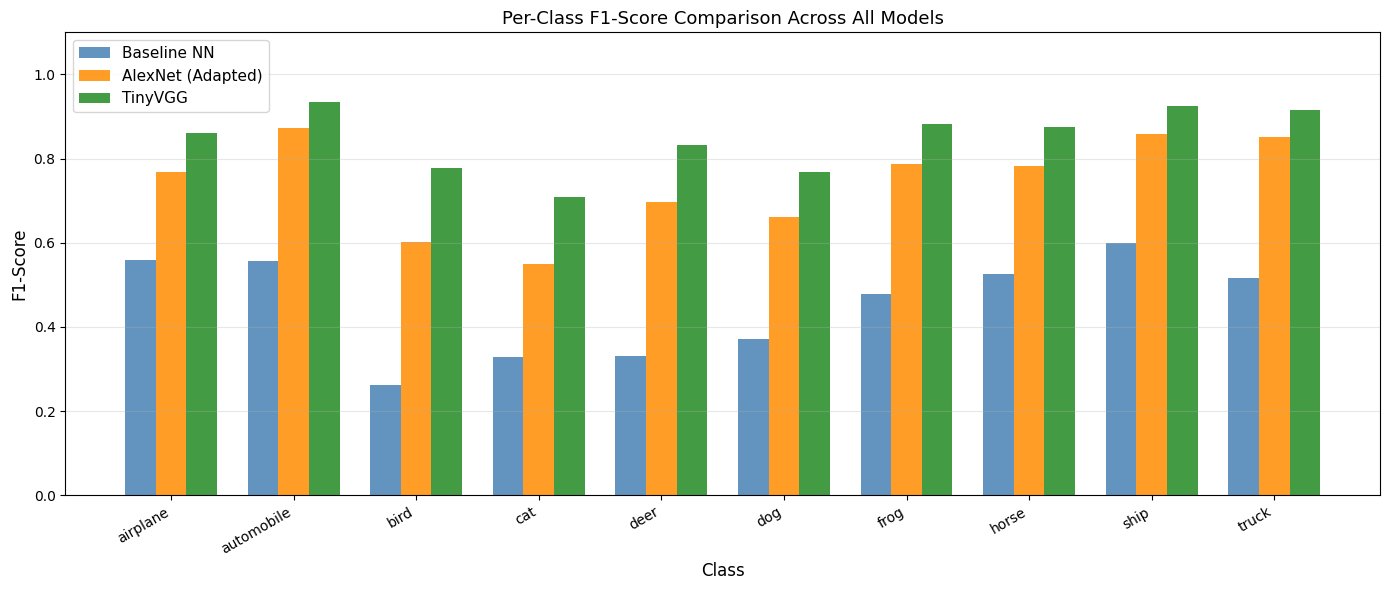

Macro F1 — Baseline NN  : 0.4532
Macro F1 — AlexNet      : 0.7430
Macro F1 — TinyVGG      : 0.8482


In [16]:
from sklearn.metrics import f1_score

f1_nn   = f1_score(labels_nn,   preds_nn,   average=None)
f1_alex = f1_score(labels_alex, preds_alex, average=None)
f1_vgg  = f1_score(labels_vgg,  preds_vgg,  average=None)

x = np.arange(len(CLASSES))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, f1_nn,   width, label='Baseline NN',       alpha=0.85, color='steelblue')
bars2 = ax.bar(x,         f1_alex, width, label='AlexNet (Adapted)',  alpha=0.85, color='darkorange')
bars3 = ax.bar(x + width, f1_vgg,  width, label='TinyVGG',            alpha=0.85, color='forestgreen')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison Across All Models', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=30, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print macro F1
print(f"Macro F1 — Baseline NN  : {f1_nn.mean():.4f}")
print(f"Macro F1 — AlexNet      : {f1_alex.mean():.4f}")
print(f"Macro F1 — TinyVGG      : {f1_vgg.mean():.4f}")

## Model Complexity Analysis

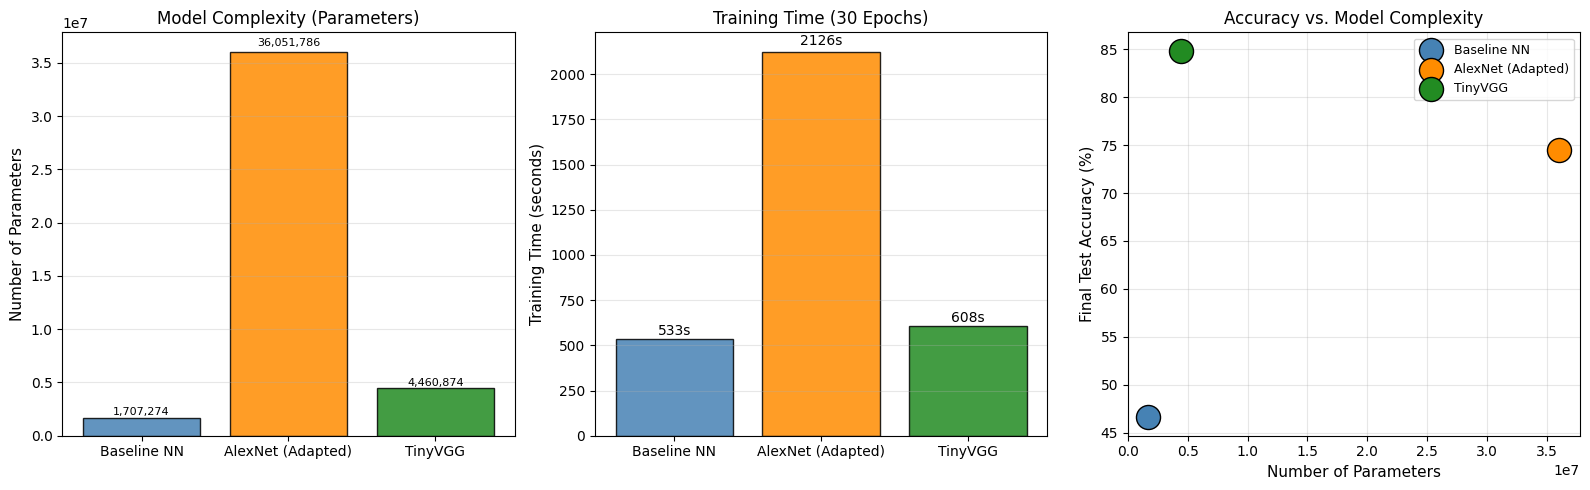


Detailed Complexity Table:
            Model  Parameters  Size (MB)    Time (s)  Final Test Acc (%)
      Baseline NN     1707274   6.512733  533.279137               46.59
AlexNet (Adapted)    36051786 137.526649 2125.567907               74.46
          TinyVGG     4460874  17.016884  607.637236               84.86


In [17]:
def model_size_mb(model):
    """Calculate model size in MB (float32 parameters)."""
    return count_parameters(model) * 4 / (1024 ** 2)

model_data = {
    'Model':       ['Baseline NN', 'AlexNet (Adapted)', 'TinyVGG'],
    'Parameters':  [count_parameters(baseline_nn), count_parameters(alexnet_model), count_parameters(tinyvgg_model)],
    'Size (MB)':   [model_size_mb(baseline_nn), model_size_mb(alexnet_model), model_size_mb(tinyvgg_model)],
    'Time (s)':    [history_nn['training_time'], history_alex['training_time'], history_vgg['training_time']],
    'Final Test Acc (%)': [history_nn['test_acc'][-1], history_alex['test_acc'][-1], history_vgg['test_acc'][-1]],
}

df_complexity = pd.DataFrame(model_data)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['steelblue', 'darkorange', 'forestgreen']

# Parameters
axes[0].bar(df_complexity['Model'], df_complexity['Parameters'], color=colors, alpha=0.85, edgecolor='black')
axes[0].set_ylabel('Number of Parameters', fontsize=11)
axes[0].set_title('Model Complexity (Parameters)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(axes[0].patches, df_complexity['Parameters'])):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.01,
                 f'{val:,}', ha='center', va='bottom', fontsize=8)

# Training Time
axes[1].bar(df_complexity['Model'], df_complexity['Time (s)'], color=colors, alpha=0.85, edgecolor='black')
axes[1].set_ylabel('Training Time (seconds)', fontsize=11)
axes[1].set_title(f'Training Time ({EPOCHS} Epochs)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(axes[1].patches, df_complexity['Time (s)']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.01,
                 f'{val:.0f}s', ha='center', va='bottom', fontsize=10)

# Accuracy vs Parameters scatter
for name, params, acc, color in zip(df_complexity['Model'], df_complexity['Parameters'],
                                     df_complexity['Final Test Acc (%)'], colors):
    axes[2].scatter(params, acc, s=300, color=color, label=name, zorder=5, edgecolors='black')
axes[2].set_xlabel('Number of Parameters', fontsize=11)
axes[2].set_ylabel('Final Test Accuracy (%)', fontsize=11)
axes[2].set_title('Accuracy vs. Model Complexity', fontsize=12)
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDetailed Complexity Table:")
print(df_complexity.to_string(index=False))

## Discussion

The experimental results reveal clear performance differences among the Baseline Neural Network, AlexNet (adapted), and TinyVGG models.

The **Baseline Neural Network** performs the worst because it treats images as flattened vectors and does not exploit spatial relationships between pixels. This limits its ability to learn important visual features such as edges, shapes, and textures, resulting in low classification accuracy and weak generalization performance.

The **AlexNet model** shows a significant improvement by using convolutional layers to learn hierarchical spatial features. However, due to its very large number of parameters relative to the CIFAR-10 dataset size, it suffers from overfitting and requires longer training time. While AlexNet represents a major milestone in deep learning, it is not ideally suited for small image datasets.

The **TinyVGG model** achieves the best overall performance. Its use of Batch Normalization stabilizes training and reduces overfitting, while its smaller parameter count makes it better matched to the dataset. TinyVGG converges faster and achieves higher accuracy with a smaller train–test performance gap.

Analysis of the confusion matrices shows that visually similar classes, such as cats and dogs or automobiles and trucks, are commonly confused across all models. However, the CNN-based models—especially TinyVGG—exhibit stronger class separation and clearer diagonal dominance.

## Conclusion

This experiment demonstrates that **convolutional neural networks significantly outperform fully connected networks for image classification tasks**.

The Baseline Neural Network is fundamentally limited by its lack of spatial feature learning, leading to poor performance. AlexNet substantially improves accuracy by learning hierarchical visual representations but exhibits overfitting due to its large model size. TinyVGG provides the best balance between accuracy, training efficiency, and generalization.

Overall, the results highlight that **effective architectural design and appropriate model complexity are more important than sheer model size**. For CIFAR-10–scale image classification problems, TinyVGG represents the most practical and effective choice.